In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import os
from glob import glob
from collections import OrderedDict
import xarray as xr
import numpy as np

import ncar_jobqueue
from dask.distributed import Client

import esmlab
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
from scipy import stats
import pop_tools 

from statistics import mean
from matplotlib import style
from scipy import stats
import pandas as pd

style.use('default')
import matplotlib.path as mpath

In [2]:
case = 'g.e22a06.G1850ECOIAF_JRA_PHYS_DEV.TL319_g17.4p4z.zoo4longlived2'
path = '/glade/scratch/kristenk/archive/' + case + '/ocn/proc/tseries/year_1'
variables = ['diatC', 'coccoC','spC','diazC','zoo1C','zoo2C','zoo3C','zoo4C',
             'IFRAC','PD','Fe']
coords = {'x':'TLONG','y':'TLAT'}
keepthese = ['z_t','time_bound','TAREA','REGION_MASK', 'time'] + variables
keep_vars = keepthese +list(coords.values())+['dz','KMT']

#### get case

In [3]:
%%time
ds_list = []
print(f'reading {case}')
ds = xr.Dataset()

for v in variables:  
    print(v)
    files = sorted(glob(f'{path}/{case}.annual.{v}.????-????.nc'))       
    dsv=xr.open_mfdataset(files, data_vars="minimal", coords='minimal', compat="override", parallel=True, concat_dim="time",
                       drop_variables=["transport_components", "transport_regions"], decode_times=True)
    
    ds = xr.merge((ds, dsv))
    ds_list.append(ds)

reading g.e22a06.G1850ECOIAF_JRA_PHYS_DEV.TL319_g17.4p4z.zoo4longlived2
diatC
coccoC
spC
diazC
zoo1C
zoo2C
zoo3C
zoo4C
IFRAC
PD
Fe
CPU times: user 2.77 s, sys: 391 ms, total: 3.16 s
Wall time: 4.61 s


In [4]:
tmp = ds.zoo1C * 10.
ds['zoo1C_zint'] = tmp.where(tmp>0).sum(dim='z_t_150m')
tmp = ds.zoo2C * 10.
ds['zoo2C_zint'] = tmp.sum(dim='z_t_150m')
tmp = ds.zoo3C * 10.
ds['zoo3C_zint'] = tmp.sum(dim='z_t_150m')
tmp = ds.zoo4C * 10.
ds['zoo4C_zint'] = tmp.sum(dim='z_t_150m')

ds['zooC_TOT_zint'] = ds['zoo1C_zint'] + ds['zoo2C_zint'] + ds['zoo3C_zint'] + ds['zoo4C_zint']

tmp = ds.spC * 10.
ds['spC_zint'] = tmp.sum(dim='z_t_150m')
tmp = ds.diatC * 10.
ds['diatC_zint'] = tmp.sum(dim='z_t_150m')
tmp = ds.coccoC * 10.
ds['coccoC_zint'] = tmp.sum(dim='z_t_150m')
tmp = ds.diazC * 10.
ds['diazC_zint'] = tmp.sum(dim='z_t_150m')

ds['phytoC_TOT_zint'] = ds['spC_zint'] + ds['diatC_zint'] + ds['coccoC_zint'] + ds['diazC_zint']

In [9]:
ds['diat_sp_ratio'] = ds.diatC_zint/ds.spC_zint
ds['zoo_phyto_ratio'] = ds.zooC_TOT_zint/ds.phytoC_TOT_zint

In [6]:
ds_grid = pop_tools.get_grid('POP_gx1v7')
lons=ds_grid.TLONG
lats=ds_grid.TLAT
area=ds_grid.TAREA
area_m=ds_grid.TAREA * 1.e-4
depths=ds_grid.z_t * 0.01
tlen=len(ds.time)
years = np.arange(1999,1999+tlen,1)
years

array([1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009,
       2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018])

### Get SAM indices

In [7]:
csv_file = '/glade/work/kristenk/SAM_index/SAM_indices.csv'
sam_indices = pd.read_csv(csv_file, header=None)
sam_indices.columns = ['year', 'ANN', 'AUT' , 'WIN', 'SPR', 'SUM']
sam_indices

,year,ANN,AUT,WIN,SPR,SUM
0,1957,-4.24,-2.52,-0.68,-3.55,-2.52
1,1958,-1.27,-2.97,-0.92,1.42,1.12
2,1959,0.47,-0.94,-1.22,3.20,0.31
3,1960,1.52,0.74,0.32,1.00,-0.08
4,1961,1.22,0.48,0.93,0.85,2.19
...,...,...,...,...,...,...
58,2015,4.13,1.43,3.19,1.75,2.19
59,2016,1.67,1.64,1.49,-0.31,-1.75
60,2017,1.67,1.34,1.15,1.42,2.33
61,2018,1.96,-0.81,-0.76,3.92,1.43


### plotting function (helps with South Pole stereographic map)

In [10]:
def adjust_pop_grid(tlon,tlat,field):
    nj = tlon.shape[0]
    ni = tlon.shape[1]
    xL = int(ni/2 - 1)
    xR = int(xL + ni)

    tlon = np.where(np.greater_equal(tlon,min(tlon[:,0])),tlon-360.,tlon)
    lon  = np.concatenate((tlon,tlon+360.),1)
    lon = lon[:,xL:xR]

    if ni == 320:
        lon[367:-3,0] = lon[367:-3,0]+360.
    lon = lon - 360.
    lon = np.hstack((lon,lon[:,0:1]+360.))
    if ni == 320:
        lon[367:,-1] = lon[367:,-1] - 360.

    #-- trick cartopy into doing the right thing:
    #   it gets confused when the cyclic coords are identical
    lon[:,0] = lon[:,0]-1e-8
    
    #-- periodicity
    lat  = np.concatenate((tlat,tlat),1)
    lat = lat[:,xL:xR]
    lat = np.hstack((lat,lat[:,0:1]))

    field = np.ma.concatenate((field,field),1)
    field = field[:,xL:xR]
    field = np.ma.hstack((field,field[:,0:1]))
    return lon,lat,field

### do mean, st dev, and mean/stdev calculations

In [12]:
st_dev_diat_sp = ds.diat_sp_ratio.std(dim='time').where(ds.PD.isel(z_t=0,time=0)>0.)
mean_diat_sp = ds.diat_sp_ratio.mean(dim='time').where(ds.PD.isel(z_t=0,time=0)>0.)
norm_stdev_diat_sp = st_dev_diat_sp/mean_diat_sp

st_dev_zoo_phyto = ds.zoo_phyto_ratio.std(dim='time').where(ds.PD.isel(z_t=0,time=0)>0.)
mean_zoo_phyto = ds.zoo_phyto_ratio.mean(dim='time').where(ds.PD.isel(z_t=0,time=0)>0.)
norm_stdev_zoo_phyto = st_dev_zoo_phyto/mean_zoo_phyto

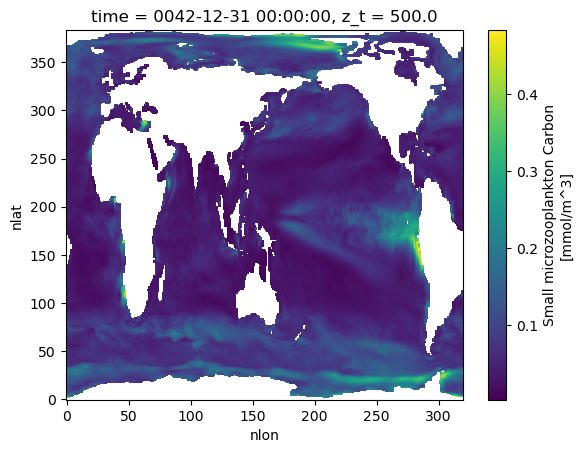

In [13]:
norm_stdev_zoo_phyto.plot()

### Do SAM annual correlations

In [15]:
ann_sam = sam_indices.ANN.values
time_sam = sam_indices.year.values

na = np.newaxis
da_sam = ann_sam[:,na,na]
da_sam = xr.DataArray(da_sam, dims=('time','lat','lon'))

#just get the overlapping timeperiod with the model
da_sam = da_sam.isel(time=slice(42,62))

In [16]:
diat_sp_sam_ann_corr = xr.corr(ds.diat_sp_ratio, da_sam, dim='time')
diat_sp_sam_ann_corr = diat_sp_sam_ann_corr.squeeze()

zoo_phyto_sam_ann_corr = xr.corr(ds.zoo_phyto_ratio, da_sam, dim='time')
zoo_phyto_sam_ann_corr = zoo_phyto_sam_ann_corr.squeeze()


### Do SAM summer correlations

In [17]:
sum_sam = sam_indices.SUM.values
time_sam = sam_indices.year.values

na = np.newaxis
da_sam_sum = sum_sam[:,na,na]
da_sam_sum = xr.DataArray(da_sam_sum, dims=('time','lat','lon'))

#just get the overlapping timeperiod with the model
da_sam_sum = da_sam_sum.isel(time=slice(42,62))

In [18]:
diat_sp_sam_sum_corr = xr.corr(ds.diat_sp_ratio, da_sam_sum, dim='time')
diat_sp_sam_sum_corr = diat_sp_sam_sum_corr.squeeze()

zoo_phyto_sam_sum_corr = xr.corr(ds.zoo_phyto_ratio, da_sam_sum, dim='time')
zoo_phyto_sam_sum_corr = zoo_phyto_sam_sum_corr.squeeze()


### Do SAM winter correlations

In [19]:
win_sam = sam_indices.WIN.values
time_sam = sam_indices.year.values

na = np.newaxis
da_sam_win = win_sam[:,na,na]
da_sam_win = xr.DataArray(da_sam_win, dims=('time','lat','lon'))

#just get the overlapping timeperiod with the model
da_sam_win = da_sam_win.isel(time=slice(42,62))

In [20]:
diat_sp_sam_win_corr = xr.corr(ds.diat_sp_ratio, da_sam_win, dim='time')
diat_sp_sam_win_corr = diat_sp_sam_win_corr.squeeze()

zoo_phyto_sam_win_corr = xr.corr(ds.zoo_phyto_ratio, da_sam_win, dim='time')
zoo_phyto_sam_win_corr = zoo_phyto_sam_win_corr.squeeze()


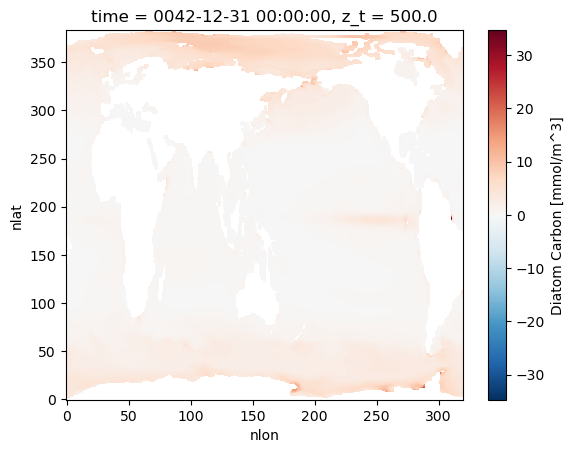

In [21]:
mean_diat_sp.plot()

### diatC/spC plots

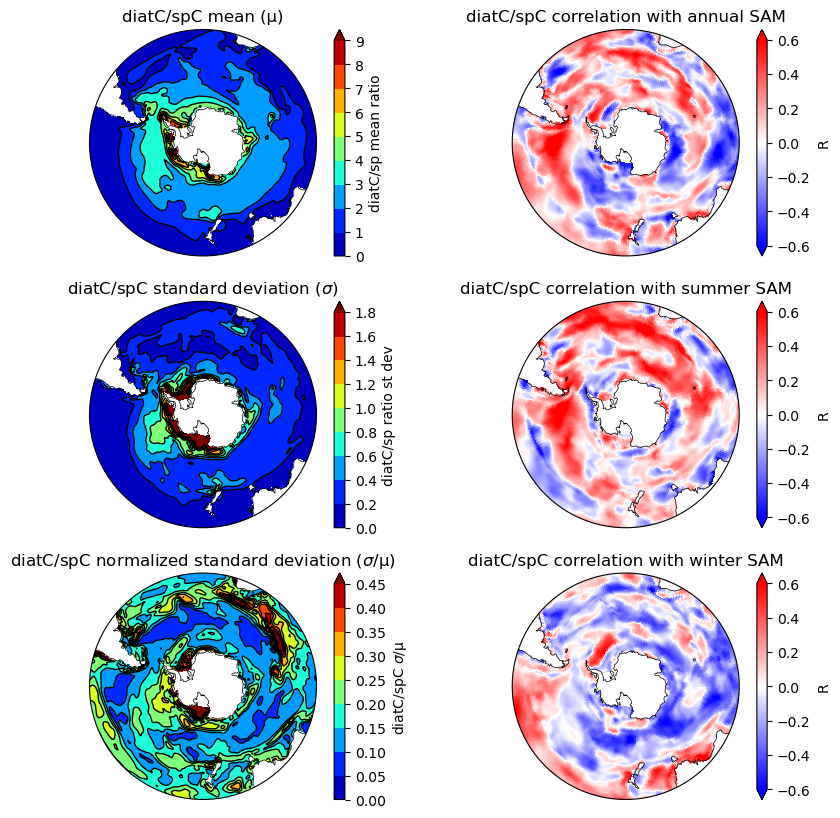

In [29]:
fig = plt.figure(figsize=(10,10))


#----------PLOT MEAN STATE---------------------------------------------------
lon, lat, field = adjust_pop_grid(lons, lats, mean_diat_sp)
sh = lat[:, 0] < 0
lon = lon[sh, :]
lat = lat[sh, :]
field = field[sh, :]
contour_specs1 = {'levels': np.arange(0,10,1)}

ax = fig.add_subplot(3,2,1, projection=ccrs.SouthPolarStereo())
ax.set_title('diatC/spC mean (µ)')
ax.set_extent([-180, 180, -90, -30], ccrs.PlateCarree())

#################### make it a circle
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

ax.set_boundary(circle, transform=ax.transAxes)
#################### end circle

cf = ax.contourf(lon,lat,field,
                     transform=ccrs.PlateCarree(),cmap='jet',extend='max',**contour_specs1)
cs = ax.contour(lon,lat,field, colors='black',
                levels = contour_specs1['levels'],
                linewidths = 1,
                transform=ccrs.PlateCarree())
ax.coastlines('110m',linewidth=0.5)
cbar1 = fig.colorbar(cf, ax=ax,extend='max',label='diatC/sp mean ratio')

#----------PLOT ST DEV ---------------------------------------------------
lon, lat, field = adjust_pop_grid(lons, lats, st_dev_diat_sp)
sh = lat[:, 0] < 0
lon = lon[sh, :]
lat = lat[sh, :]
field = field[sh, :]
contour_specs1 = {'levels': np.arange(0,2,0.2)}

ax = fig.add_subplot(3,2,3, projection=ccrs.SouthPolarStereo())
ax.set_title('diatC/spC standard deviation (${\sigma}$)')
ax.set_extent([-180, 180, -90, -30], ccrs.PlateCarree())

#################### make it a circle
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

ax.set_boundary(circle, transform=ax.transAxes)
#################### end circle

cf = ax.contourf(lon,lat,field,
                     transform=ccrs.PlateCarree(),cmap='jet',extend='max',**contour_specs1)
cs = ax.contour(lon,lat,field, colors='black',
                levels = contour_specs1['levels'],
                linewidths = 1,
                transform=ccrs.PlateCarree())

ax.coastlines('110m',linewidth=0.5)
cbar1 = fig.colorbar(cf, ax=ax,extend='max',label='diatC/sp ratio st dev')

#----------PLOT MEAN/ST DEV ---------------------------------------------------
lon, lat, field = adjust_pop_grid(lons, lats, norm_stdev_diat_sp)
sh = lat[:, 0] < 0
lon = lon[sh, :]
lat = lat[sh, :]
field = field[sh, :]
contour_specs1 = {'levels': np.arange(0,0.5,0.05)}

ax = fig.add_subplot(3,2,5, projection=ccrs.SouthPolarStereo())
ax.set_title('diatC/spC normalized standard deviation (${\sigma}$/µ)')
ax.set_extent([-180, 180, -90, -30], ccrs.PlateCarree())

#################### make it a circle
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

ax.set_boundary(circle, transform=ax.transAxes)
#################### end circle

cf = ax.contourf(lon,lat,field,
                     transform=ccrs.PlateCarree(),cmap='jet',extend='max',**contour_specs1)
cs = ax.contour(lon,lat,field, colors='black',
                levels = contour_specs1['levels'],
                linewidths = 1,
                transform=ccrs.PlateCarree())

ax.coastlines('110m',linewidth=0.5)
cbar1 = fig.colorbar(cf, ax=ax,extend='max',label='diatC/spC ${\sigma}$/µ')

#----------PLOT SAM annual correlation ---------------------------------------------------
lon, lat, field = adjust_pop_grid(lons, lats, diat_sp_sam_ann_corr)
sh = lat[:, 0] < 0
lon = lon[sh, :]
lat = lat[sh, :]
field = field[sh, :]

ax = fig.add_subplot(3,2,2, projection=ccrs.SouthPolarStereo())
ax.set_title('diatC/spC correlation with annual SAM')
ax.set_extent([-180, 180, -90, -30], ccrs.PlateCarree())

#################### make it a circle
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

ax.set_boundary(circle, transform=ax.transAxes)
#################### end circle

pc=ax.pcolormesh(lon, lat, 
                 field, vmin=-0.6, vmax=0.6, 
                 cmap='bwr',
                 transform=ccrs.PlateCarree())

ax.coastlines('110m',linewidth=0.5)
cbar1 = fig.colorbar(pc, ax=ax,extend='both',label='R')

#----------PLOT SAM summer correlation ---------------------------------------------------
lon, lat, field = adjust_pop_grid(lons, lats, diat_sp_sam_sum_corr)
sh = lat[:, 0] < 0
lon = lon[sh, :]
lat = lat[sh, :]
field = field[sh, :]

ax = fig.add_subplot(3,2,4, projection=ccrs.SouthPolarStereo())
ax.set_title('diatC/spC correlation with summer SAM')
ax.set_extent([-180, 180, -90, -30], ccrs.PlateCarree())

#################### make it a circle
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

ax.set_boundary(circle, transform=ax.transAxes)
#################### end circle

pc=ax.pcolormesh(lon, lat, 
                 field, vmin=-0.6, vmax=0.6, 
                 cmap='bwr',
                 transform=ccrs.PlateCarree())

ax.coastlines('110m',linewidth=0.5)
cbar1 = fig.colorbar(pc, ax=ax,extend='both',label='R')

#----------PLOT SAM winter correlation ---------------------------------------------------
lon, lat, field = adjust_pop_grid(lons, lats, diat_sp_sam_win_corr)
sh = lat[:, 0] < 0
lon = lon[sh, :]
lat = lat[sh, :]
field = field[sh, :]

ax = fig.add_subplot(3,2,6, projection=ccrs.SouthPolarStereo())
ax.set_title('diatC/spC correlation with winter SAM')
ax.set_extent([-180, 180, -90, -30], ccrs.PlateCarree())

#################### make it a circle
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

ax.set_boundary(circle, transform=ax.transAxes)
#################### end circle

pc=ax.pcolormesh(lon, lat, 
                 field, vmin=-0.6, vmax=0.6, 
                 cmap='bwr',
                 transform=ccrs.PlateCarree())

ax.coastlines('110m',linewidth=0.5)
cbar1 = fig.colorbar(pc, ax=ax,extend='both',label='R')

### zooC/phytoC

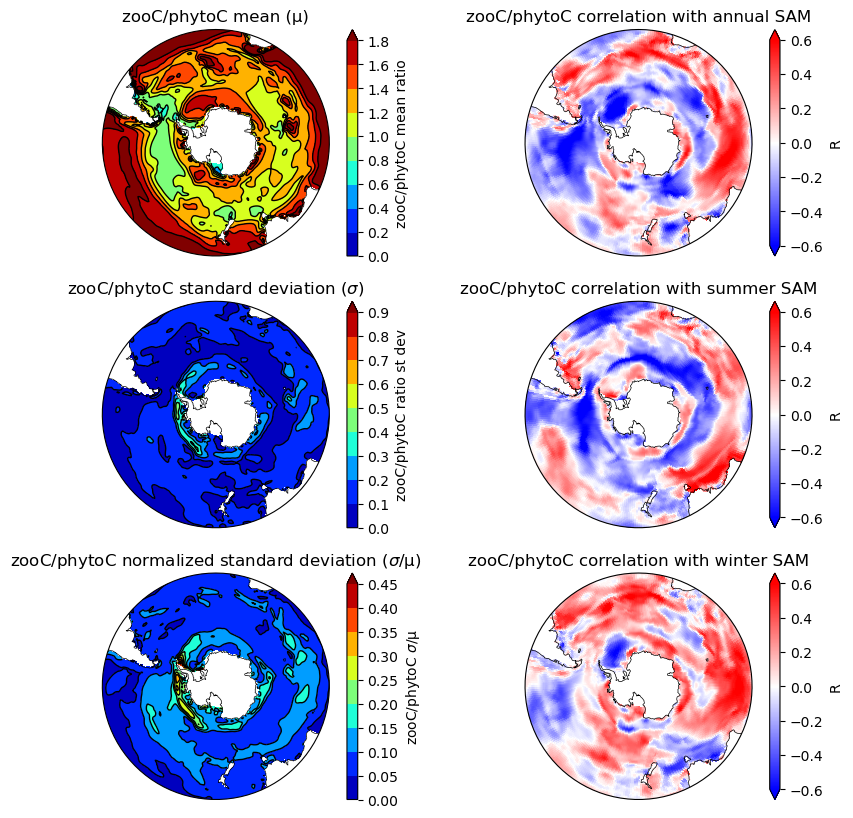

In [31]:
fig = plt.figure(figsize=(10,10))


#----------PLOT MEAN STATE---------------------------------------------------
lon, lat, field = adjust_pop_grid(lons, lats, mean_zoo_phyto)
sh = lat[:, 0] < 0
lon = lon[sh, :]
lat = lat[sh, :]
field = field[sh, :]
contour_specs1 = {'levels': np.arange(0,2,0.2)}

ax = fig.add_subplot(3,2,1, projection=ccrs.SouthPolarStereo())
ax.set_title('zooC/phytoC mean (µ)')
ax.set_extent([-180, 180, -90, -30], ccrs.PlateCarree())

#################### make it a circle
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

ax.set_boundary(circle, transform=ax.transAxes)
#################### end circle

cf = ax.contourf(lon,lat,field,
                     transform=ccrs.PlateCarree(),cmap='jet',extend='max',**contour_specs1)
cs = ax.contour(lon,lat,field, colors='black',
                levels = contour_specs1['levels'],
                linewidths = 1,
                transform=ccrs.PlateCarree())
ax.coastlines('110m',linewidth=0.5)
cbar1 = fig.colorbar(cf, ax=ax,extend='max',label='zooC/phytoC mean ratio')

#----------PLOT ST DEV ---------------------------------------------------
lon, lat, field = adjust_pop_grid(lons, lats, st_dev_zoo_phyto)
sh = lat[:, 0] < 0
lon = lon[sh, :]
lat = lat[sh, :]
field = field[sh, :]
contour_specs1 = {'levels': np.arange(0,1,0.1)}

ax = fig.add_subplot(3,2,3, projection=ccrs.SouthPolarStereo())
ax.set_title('zooC/phytoC standard deviation (${\sigma}$)')
ax.set_extent([-180, 180, -90, -30], ccrs.PlateCarree())

#################### make it a circle
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

ax.set_boundary(circle, transform=ax.transAxes)
#################### end circle

cf = ax.contourf(lon,lat,field,
                     transform=ccrs.PlateCarree(),cmap='jet',extend='max',**contour_specs1)
cs = ax.contour(lon,lat,field, colors='black',
                levels = contour_specs1['levels'],
                linewidths = 1,
                transform=ccrs.PlateCarree())

ax.coastlines('110m',linewidth=0.5)
cbar1 = fig.colorbar(cf, ax=ax,extend='max',label='zooC/phytoC ratio st dev')

#----------PLOT MEAN/ST DEV ---------------------------------------------------
lon, lat, field = adjust_pop_grid(lons, lats, norm_stdev_zoo_phyto)
sh = lat[:, 0] < 0
lon = lon[sh, :]
lat = lat[sh, :]
field = field[sh, :]
contour_specs1 = {'levels': np.arange(0,0.5,0.05)}

ax = fig.add_subplot(3,2,5, projection=ccrs.SouthPolarStereo())
ax.set_title('zooC/phytoC normalized standard deviation (${\sigma}$/µ)')
ax.set_extent([-180, 180, -90, -30], ccrs.PlateCarree())

#################### make it a circle
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

ax.set_boundary(circle, transform=ax.transAxes)
#################### end circle

cf = ax.contourf(lon,lat,field,
                     transform=ccrs.PlateCarree(),cmap='jet',extend='max',**contour_specs1)
cs = ax.contour(lon,lat,field, colors='black',
                levels = contour_specs1['levels'],
                linewidths = 1,
                transform=ccrs.PlateCarree())

ax.coastlines('110m',linewidth=0.5)
cbar1 = fig.colorbar(cf, ax=ax,extend='max',label='zooC/phytoC ${\sigma}$/µ')

#----------PLOT SAM annual correlation ---------------------------------------------------
lon, lat, field = adjust_pop_grid(lons, lats, zoo_phyto_sam_ann_corr)
sh = lat[:, 0] < 0
lon = lon[sh, :]
lat = lat[sh, :]
field = field[sh, :]

ax = fig.add_subplot(3,2,2, projection=ccrs.SouthPolarStereo())
ax.set_title('zooC/phytoC correlation with annual SAM')
ax.set_extent([-180, 180, -90, -30], ccrs.PlateCarree())

#################### make it a circle
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

ax.set_boundary(circle, transform=ax.transAxes)
#################### end circle

pc=ax.pcolormesh(lon, lat, 
                 field, vmin=-0.6, vmax=0.6, 
                 cmap='bwr',
                 transform=ccrs.PlateCarree())

ax.coastlines('110m',linewidth=0.5)
cbar1 = fig.colorbar(pc, ax=ax,extend='both',label='R')

#----------PLOT SAM summer correlation ---------------------------------------------------
lon, lat, field = adjust_pop_grid(lons, lats, zoo_phyto_sam_sum_corr)
sh = lat[:, 0] < 0
lon = lon[sh, :]
lat = lat[sh, :]
field = field[sh, :]

ax = fig.add_subplot(3,2,4, projection=ccrs.SouthPolarStereo())
ax.set_title('zooC/phytoC correlation with summer SAM')
ax.set_extent([-180, 180, -90, -30], ccrs.PlateCarree())

#################### make it a circle
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

ax.set_boundary(circle, transform=ax.transAxes)
#################### end circle

pc=ax.pcolormesh(lon, lat, 
                 field, vmin=-0.6, vmax=0.6, 
                 cmap='bwr',
                 transform=ccrs.PlateCarree())

ax.coastlines('110m',linewidth=0.5)
cbar1 = fig.colorbar(pc, ax=ax,extend='both',label='R')

#----------PLOT SAM winter correlation ---------------------------------------------------
lon, lat, field = adjust_pop_grid(lons, lats, zoo_phyto_sam_win_corr)
sh = lat[:, 0] < 0
lon = lon[sh, :]
lat = lat[sh, :]
field = field[sh, :]

ax = fig.add_subplot(3,2,6, projection=ccrs.SouthPolarStereo())
ax.set_title('zooC/phytoC correlation with winter SAM')
ax.set_extent([-180, 180, -90, -30], ccrs.PlateCarree())

#################### make it a circle
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

ax.set_boundary(circle, transform=ax.transAxes)
#################### end circle

pc=ax.pcolormesh(lon, lat, 
                 field, vmin=-0.6, vmax=0.6, 
                 cmap='bwr',
                 transform=ccrs.PlateCarree())

ax.coastlines('110m',linewidth=0.5)
cbar1 = fig.colorbar(pc, ax=ax,extend='both',label='R')